In [14]:
import openfe
MyProtein = "./protein.pdb"
MyLigands = "20250509.sdf"
from rdkit import Chem
supp = Chem.SDMolSupplier(MyLigands, removeHs=False)
ligands = [openfe.SmallMoleculeComponent.from_rdkit(mol) for mol in supp]
from openfe.protocols.openmm_utils.omm_settings import OpenFFPartialChargeSettings
from openfe.protocols.openmm_utils.charge_generation import bulk_assign_partial_charges
charge_settings = OpenFFPartialChargeSettings(partial_charge_method="am1bcc", off_toolkit_backend="ambertools")
charged_ligands = bulk_assign_partial_charges(
    molecules=ligands,
    overwrite=False,
    method=charge_settings.partial_charge_method,
    toolkit_backend=charge_settings.off_toolkit_backend,
    generate_n_conformers=charge_settings.number_of_conformers,
    nagl_model=charge_settings.nagl_model,
    processors=20 #set number of Cpus
)

Generating charges: 100%|███████████████████████| 13/13 [06:41<00:00, 30.91s/it]


In [15]:
mapper = openfe.LomapAtomMapper(max3d=1.0, element_change=False)
scorer = openfe.lomap_scorers.default_lomap_score
network_planner = openfe.ligand_network_planning.generate_lomap_network

ligand_network = network_planner(
    ligands=charged_ligands,
    mappers=[mapper],
    scorer=scorer
)

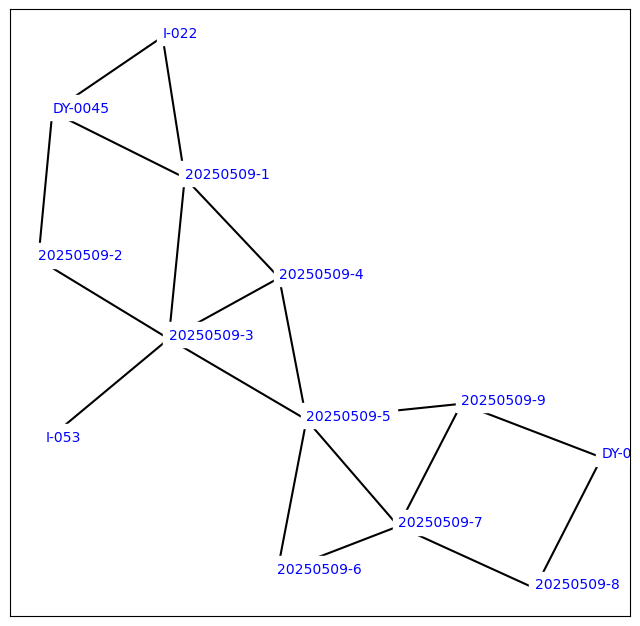

In [16]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

In [17]:
#show edge score
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

for mapping in ligand_network.edges:
    print(mapping.componentA, mapping.componentB, mapping.annotations)

#write map
with open("ligand_network.graphml", mode='w') as f:
    f.write(ligand_network.to_graphml())

SmallMoleculeComponent(name=20250509-7) SmallMoleculeComponent(name=20250509-9) {'score': 0.7408182206817179}
SmallMoleculeComponent(name=20250509-3) SmallMoleculeComponent(name=I-053) {'score': 0.7408182206817179}
SmallMoleculeComponent(name=20250509-3) SmallMoleculeComponent(name=20250509-1) {'score': 0.49658530379140947}
SmallMoleculeComponent(name=20250509-5) SmallMoleculeComponent(name=20250509-4) {'score': 0.36787944117144233}
SmallMoleculeComponent(name=20250509-4) SmallMoleculeComponent(name=20250509-3) {'score': 0.6703200460356393}
SmallMoleculeComponent(name=20250509-7) SmallMoleculeComponent(name=20250509-8) {'score': 0.36787944117144233}
SmallMoleculeComponent(name=20250509-9) SmallMoleculeComponent(name=DY-0137) {'score': 0.36787944117144233}
SmallMoleculeComponent(name=20250509-2) SmallMoleculeComponent(name=DY-0045) {'score': 0.49658530379140947}
SmallMoleculeComponent(name=DY-0045) SmallMoleculeComponent(name=I-022) {'score': 0.27253179303401254}
SmallMoleculeComponent(

In [18]:
#PROTOCOLs(simulation setting)
#define one tranformation frist
#the way to solvent and protein
solvent = openfe.SolventComponent()
protein = openfe.ProteinComponent.from_pdb_file(MyProtein)
#define system
systemA = openfe.ChemicalSystem({
    'ligand': mapping.componentA,
    'solvent': solvent,
    'protein': protein
})
systemB = openfe.ChemicalSystem({
    'ligand': mapping.componentB,
    'solvent': solvent,
    'protein': protein
})

#all your simulation parameter is writen in 'settings'
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol
settings = RelativeHybridTopologyProtocol.default_settings()

#mod paramter your want here!!!
from openff.units import unit
settings.protocol_repeats = 2
#settings.engine_settings.gpu_device_index = [1, 2, 3, 4, 5, 6] #multi GPU will make NaN.

protocol = RelativeHybridTopologyProtocol(settings)
#put everything of the protocol into 'transformation'
transformation = openfe.Transformation(
    systemA,
    systemB,
    protocol,
    mapping={'ligand': mapping},
)
#putting all the 'transformation's together in 'tranformations'
transformations = []
for mapping in ligand_network.edges:
    for leg in ['solvent', 'complex']:
        # use the solvent and protein created above
        sysA_dict = {'ligand': mapping.componentA,
                     'solvent': solvent}
        sysB_dict = {'ligand': mapping.componentB,
                     'solvent': solvent}

        if leg == 'complex':
            sysA_dict['protein'] = protein
            sysB_dict['protein'] = protein

        # we don't have to name objects, but it can make things (like filenames) more convenient
        sysA = openfe.ChemicalSystem(sysA_dict, name=f"{mapping.componentA.name}_{leg}")
        sysB = openfe.ChemicalSystem(sysB_dict, name=f"{mapping.componentB.name}_{leg}")

        prefix = "rbfe_"  # prefix is only to exactly reproduce CLI

        transformation = openfe.Transformation(
            stateA=sysA,
            stateB=sysB,
            mapping={'ligand': mapping},
            protocol=protocol,  # use protocol created above
            name=f"{prefix}{sysA.name}_{sysB.name}"
        )
        transformations.append(transformation)

network = openfe.AlchemicalNetwork(transformations)
#write 'transformations(input)'
import pathlib
transformation_dir = pathlib.Path("transformations")
transformation_dir.mkdir(exist_ok=True)
for transformation in network.edges:
    transformation.dump(transformation_dir / f"{transformation.name}.json")